TODO:

- decide on brain state data structure (maybe reformat it inside of the sim?)
- add text describing brain state/mental state/mental representation/functionalism/etc..
- clean up the NN models / function calls on the networks to make them more intuitive for explaination
- nicely package training scripts for behavior and mental state classification (implement train/test for mental state clf)
- fix all the pytorch cuda/cpu drama
- add explainations/text throughout notebook
- general notebook cleaning
- make notebook work on colab

# Overview

- Many theories of mind rest on how brain states and mental states are defined and their relationship.
- I want to try to (faithfully to most theories of mind) define brain states, mental states, and their relationships in code.
- We can then use these definitions to build descriptions of theories of mind in code.
- I am not presenting a cognitive architecture or even accepting computational theory of mind. 
- *I'm simply trying to use code to more clearly talk about what we mean and have more concrete disagreements.*
- Like a thought experiment, but with a simulate buttom.

# Notebook setup

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from IPython.display import clear_output
import world
from dqn_agent import DQNAgent
from visualization_utils import *
from model import MLP

%matplotlib inline

# Feel for the simulation world

In [2]:
%%HTML
<video width="480" height="360" controls>
  <source src="../openai_lunarlander_video.mp4" type="video/mp4">
</video>

# Feel for how agents are described

## An agent who takes no actions

In [3]:
class DoNothingAgent(object):

    def __init__(self):
        pass

    def act(self, world_observation):
        return 0

    
agent = DoNothingAgent()

_ = world.run_episode(agent)

## An agent who takes random actions

In [4]:
class RandomAgent(object):

    def __init__(self, num_actions=4):
        self.num_actions = num_actions

    def act(self, world_observation):
        return random.randint(0, self.num_actions-1)

    
agent = RandomAgent()

_ = world.run_episode(agent)

## An agent that was trained (using reinforcement learning) to perform well in the environment

In [5]:
# from dqn_agent import BehaviorNetwork

class PhsyicalistBrain(object):
    
    def __init__(self):
        self.behavior_network = DQNAgent()
        self.behavior_network.qnetwork_local.load_state_dict(torch.load('../checkpoint0.pth', 
                                                                        map_location='cpu'))
        self.behavior_network.qnetwork_local.fc1.cpu()
        self.behavior_network.qnetwork_local.fc2.cpu()
        self.behavior_network.qnetwork_local.fc3.cpu()
            
    def brain_state(self, world_observation):
        brain_state = []
        network, activations = self.behavior_network.qnetwork_local, torch.tensor(world_observation)
        for i, subnet in enumerate(network.children()):
            subbrain_state = subnet.weight.detach().clone().cpu().numpy() * activations.detach().clone().cpu().numpy()
            activations = F.relu(subnet.cpu().float()(torch.tensor(activations).float()))
            brain_state.append(subbrain_state)
        return brain_state

    def suggest_action(self, state):
        return self.behavior_network.act(state)
    

brain = PhsyicalistBrain()

In [6]:
print(brain.behavior_network.qnetwork_local)

QNetwork(
  (fc1): Linear(in_features=8, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
)


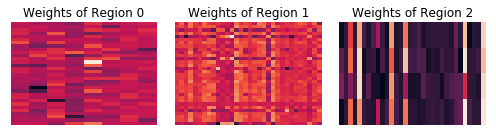

In [7]:
visualize_weights(brain.behavior_network.qnetwork_local)

INSERT LINK TO TRAINING NOTEBOOK

In [8]:
class TrainedBehaviorAgent(object):

    def __init__(self):
        self.brain = PhsyicalistBrain()

    def act(self, world_observation):
        return self.brain.suggest_action(world_observation)
    
    def image_brain_state(self, world_observation):
        return self.brain.brain_state(world_observation)

    
agent = TrainedBehaviorAgent()

episode_history = world.run_episode(agent)

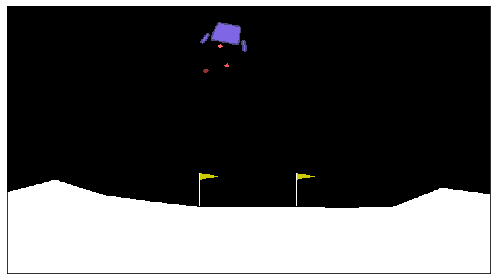

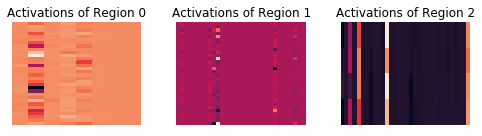

In [9]:
episode_index = 50
visualize_state(episode_history['world_image'][episode_index])
visualize_activations(agent.brain.behavior_network.qnetwork_local, episode_history['world_observation'][episode_index])

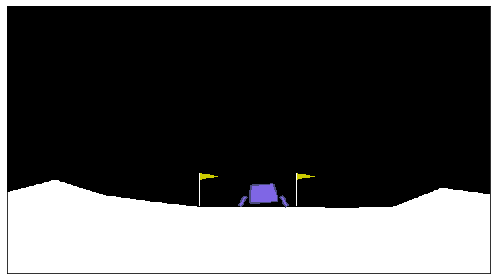

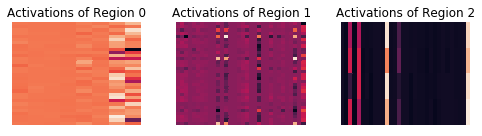

In [10]:
episode_index = -50
visualize_state(episode_history['world_image'][episode_index])
visualize_activations(agent.brain.behavior_network.qnetwork_local, episode_history['world_observation'][episode_index])

## An agent that was trained (using reinforcement learning) to perform well in the environment and was trained (using supervised learning) to recognize its own mental states

In [11]:
subjective_mental_state_to_behavior_mapping = [
    lambda state: state[3] < -0.2,  # subjective mental state 1
    lambda state: state[-2] != 1 and state[-1] != 1, # subjective mental state 2
    lambda state: np.abs(state[5]) > 0.2, # subjective mental state 3
    lambda state: state[0] > 0.2, # subjective mental state 4
    lambda state: state[0] < -0.2 # subjective mental state 5
]

class EpiphenomenalMind(object):
    
    def __init__(self):
        self.mental_state_classifier = MLP(num_neurons=1408, 
                                           num_mental_states=len(subjective_mental_state_to_behavior_mapping), 
                                           fc_units=32)
        self.mental_state_classifier.load_state_dict(torch.load('../mental_classifer.pth'))
        self.mental_state_classifier.cpu()
        self.mapping = subjective_mental_state_to_behavior_mapping
    
    def subjective_mental_state(self, brain_state):
        return F.sigmoid(self.mental_state_classifier(torch.tensor(np.concatenate([array.flatten() for array in brain_state])).float())).detach().clone().cpu().numpy()

        
mind = EpiphenomenalMind()

In [12]:
print(mind.mental_state_classifier)

MLP(
  (fc1): Linear(in_features=1408, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=5, bias=True)
)


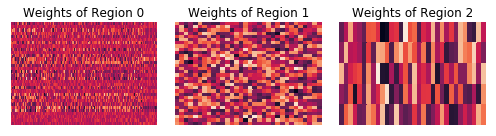

In [13]:
visualize_weights(mind.mental_state_classifier)

In [ ]:
subjective_mental_state_to_language_mapping = [
    "I believe I'm falling too fast", # subjective mental state 1
    "I desire to land", # subjective mental state 2
    "I'm afraid to tip over", # subjective mental state 3
    "I desire to go left", # subjective mental state 4
    "I desire to go right" # subjective mental state 5
]

class TrainedMentalAgent(TrainedBehaviorAgent):

    def __init__(self):
        super(TrainedMentalAgent, self).__init__()
        self.mind = EpiphenomenalMind()
        self.mapping = subjective_mental_state_to_language_mapping
        
    def report_mental_state(self, state):
        brain_state = self.brain.brain_state(state)
        mental_state = mind.subjective_mental_state(brain_state)
        return [agent.mapping[i] for i, m in enumerate(mental_state) if m > 0.5]


agent = TrainedMentalAgent()

episode_history = world.run_episode(agent)

In [ ]:
from visualization_utils import *
animate_episode_history(episode_history, agent, steps_size=25, pause=3, exclude_mental=True)

In [ ]:
animate_episode_history(episode_history, agent, steps_size=25, pause=3)

# Common theories of mind

## Behaviorism

In [ ]:
# Adapted from OpenAI's heuristic controller for lunar lander 

class BehaviorismAgent(object):

    def __init__(self, num_actions=4):
        self.num_actions = num_actions

    def act(self, world_observation):
        s = world_observation
        angle_todo = (s[0]*0.5 + s[2]*1.0 - s[4])*0.5 - (s[5])*1.0
        hover_todo = (0.55*np.abs(s[0]) - s[1])*0.5 - (s[3])*0.5
        if s[6] or s[7]:
            angle_todo, hover_todo = 0, -(s[3])*0.5 
        a = 0
        if hover_todo > np.abs(angle_todo) and hover_todo > 0.05:
            a = 2
        elif angle_todo < -0.05: 
            a = 3
        elif angle_todo > +0.05: 
            a = 1
        return a

    
agent = BehaviorismAgent()

episode_history = world.run_episode(agent)

episode_history['brain_state'] = None
episode_history['reported_mental_state'] = None

In [ ]:
animate_episode_history(episode_history, agent, steps_size=50, pause=1)

## Token-token Identity Theory

In [ ]:
agent = TrainedMentalAgent()

episode_history = world.run_episode(agent)

In [ ]:
state = np.asarray([0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=np.float32)
print('\n'.join(agent.report_mental_state(state)))
brain_state = np.concatenate([array.flatten() for array in agent.brain.brain_state(state)])
visualize_activations(agent.brain.behavior_network.qnetwork_local, state)
visualize_subjective_mental_state(agent, brain_state)

In [ ]:
state = np.asarray([0.0, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=np.float32)
print('\n'.join(agent.report_mental_state(state)))
brain_state = np.concatenate([array.flatten() for array in agent.brain.brain_state(state)])
visualize_activations(agent.brain.behavior_network.qnetwork_local, state)
visualize_subjective_mental_state(agent, brain_state)

In [ ]:
state = np.asarray([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0], dtype=np.float32)
print('\n'.join(agent.report_mental_state(state)))
brain_state = np.concatenate([array.flatten() for array in agent.brain.brain_state(state)])
visualize_activations(agent.brain.behavior_network.qnetwork_local, state)
visualize_subjective_mental_state(agent, brain_state)

In [ ]:
state = np.asarray([1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0], dtype=np.float32)
print('\n'.join(agent.report_mental_state(state)))
brain_state = np.concatenate([array.flatten() for array in agent.brain.brain_state(state)])
visualize_activations(agent.brain.behavior_network.qnetwork_local, state)
visualize_subjective_mental_state(agent, brain_state)

## Functionalism

In [ ]:
class FunctionalismAgent(object):

    def __init__(self, num_actions=4):
        self.num_actions = num_actions

    def act(self, world_observation):
        
        if self.falling_too_fast_belief_mental_state(world_observation):
            a = 2
        elif self.fear_of_tipping_to_the_left(world_observation):
            a = 3
        elif self.fear_of_tipping_to_the_right(world_observation):
            a = 1
        elif self.desire_go_left_mental_state(world_observation):
            a = 1
        elif self.desire_go_right_mental_state(world_observation):
            a = 3
        elif self.desire_to_land_mental_state(world_observation):
            a = 0
        else:
            a = 0
        return a
    
    def fear_of_tipping_to_the_left(self, world_observation):
        s = world_observation
        angle_todo = (s[0]*0.5 + s[2]*1.0 - s[4])*0.5 - (s[5])*1.0
        hover_todo = (0.55*np.abs(s[0]) - s[1])*0.5 - (s[3])*0.5
        return (not (hover_todo > np.abs(angle_todo) and hover_todo > 0.05) 
                and angle_todo < -0.05)
    
    def fear_of_tipping_to_the_right(self, world_observation):
        s = world_observation
        angle_todo = (s[0]*0.5 + s[2]*1.0 - s[4])*0.5 - (s[5])*1.0
        hover_todo = (0.55*np.abs(s[0]) - s[1])*0.5 - (s[3])*0.5
        return (not (hover_todo > np.abs(angle_todo) and hover_todo > 0.05) 
                and angle_todo > +0.05)
    
    def falling_too_fast_belief_mental_state(self, world_observation):
        return world_observation[3] < -0.2
    
    def desire_to_land_mental_state(self, world_observation):
        return (world_observation[-2] != 1 and world_observation[-1] != 1)
    
    def desire_go_left_mental_state(self, world_observation):
        return world_observation[0] > 0.1
    
    def desire_go_right_mental_state(self, world_observation):
        return world_observation[0] < -0.1
        
    
agent = FunctionalismAgent()

episode_history = world.run_episode(agent)

# Open implementation questions

## Should the mental classificaiton network be part of the brain state? How does this answer depend on the chosen theory of mind?

## The agent is epiphenomenal. We can training behavior network and the mental state classifier at the same time

# Future work

- Dennett multiple drafts model of consciousness
- Chalmers types of materialism
- Non reductive materialism: Strawson's realistic monism, Davidson's anomalous monism
- Weak emergence
- Eliminative materialism
- Searle's biological naturalism
- Thoughts? Suggestions?